# Data Transforming

In [20]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from skimage.feature import local_binary_pattern, hog
from skimage.color import rgb2gray
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, Normalizer, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
%matplotlib inline

## Xử lý ảnh

### Hàm tiền xử lý ảnh

In [21]:
def preprocess_image(image_input, size=(128, 128), to_gray=True):
    # Nếu là đường dẫn, đọc ảnh
    if isinstance(image_input, str):
        img = cv2.imread(image_input, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Không đọc được ảnh từ đường dẫn: {image_input}")
    # Nếu là ảnh ndarray, dùng trực tiếp
    elif isinstance(image_input, np.ndarray):
        img = image_input
    else:
        raise ValueError("Tham số truyền vào phải là đường dẫn hoặc ảnh numpy array")

    # Resize
    img = cv2.resize(img, size)

    # Convert to grayscale nếu cần
    if to_gray:
        if len(img.shape) == 2:
            return img
        elif len(img.shape) == 3 and img.shape[2] == 3:
            return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            raise ValueError("Ảnh có số kênh không hợp lệ")
    return img


## Trích xuất vector từ ảnh

### Extract HOG feature từ ảnh

In [22]:
def extract_hog_features_opencv(image, size=(128, 128)):

    gray = preprocess_image(image, size=size, to_gray=True)

    hog = cv2.HOGDescriptor()
    features = hog.compute(gray)
    return features.flatten()

### Extract LBP feature từ ảnh

In [23]:
def extract_lbp_features_blockwise(image_path, size=(128, 128), block_size=(16, 16), P=8, R=1, method='uniform'):
    gray = preprocess_image(image_path, size)

    lbp = local_binary_pattern(gray, P, R, method)

    h, w = size
    bh, bw = block_size
    blocks_y = h // bh
    blocks_x = w // bw

    # Xác định số bins theo method
    # if method == 'uniform':
    #     n_bins = P + 2
    # else:
    #     n_bins = 2 ** P
    n_bins=59

    features = []
    for i in range(blocks_y):
        for j in range(blocks_x):
            block = lbp[i*bh:(i+1)*bh, j*bw:(j+1)*bw]
            hist, _ = np.histogram(block.ravel(), bins=n_bins, range=(0, n_bins))
            hist = hist.astype("float32")
            hist /= (hist.sum() + 1e-6)  # chuẩn hóa
            features.extend(hist)

    return np.array(features)


### Kết hợp HOG và LBP

In [24]:
def extract_hog_lbp_features(image, size=(128, 128)):
    # Trích từng loại đặc trưng
    hog_vec = extract_hog_features_opencv(image, size=size)
    lbp_vec = extract_lbp_features_blockwise(image, size=size)

    # Gộp 2 vector lại
    combined = np.concatenate([hog_vec, lbp_vec])

    return combined

## Trích xuất vector từ các ảnh trong thư mục

### HOG

In [25]:
def load_hog_features_from_folder(folder_path, label_value, size=(128, 128)):
    X_list = []

    for file in tqdm(os.listdir(folder_path), desc=f"Đang xử lý {folder_path}"):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        if img is None:
            print(f"Không đọc được ảnh: {file_path}")
            continue
        try:
            hog_vector = extract_hog_features_opencv(img, size=size)
            X_list.append(hog_vector)
        except Exception as e:
            print(f"Lỗi xử lý ảnh {file_path}: {e}")

    # Chuyển sang NumPy array
    X = np.array(X_list, dtype=np.float32)
    return X


### LBP 

In [26]:
def load_lbp_features_from_folder(folder_path, label_value, size=(128, 128),
                                  block_size=(16, 16), P=8, R=1, method='uniform', max_images=None):
    
    X_list = []

    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if max_images:
        files = files[:max_images]

    for file in tqdm(files, desc=f"Đang xử lý {folder_path}"):
        file_path = os.path.join(folder_path, file)
        try:
            lbp_vector = extract_lbp_features_blockwise(
                file_path, size=size, block_size=block_size,
                P=P, R=R, method=method
            )
            X_list.append(lbp_vector)
        except Exception as e:
            print(f"Lỗi xử lý ảnh {file_path}: {e}")

    X = np.array(X_list, dtype=np.float32)
    return X

### HOG + LBP

In [39]:
def load_hog_lbp_features_from_folder(folder_path, label_value, size=(128, 128),
                                      block_size=(16, 16), P=8, R=1, method='uniform',
                                      max_images=None):
    X_list = []

    # Lọc file ảnh
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if max_images:
        files = files[:max_images]

    for file in tqdm(files, desc=f"Đang xử lý {folder_path}"):
        file_path = os.path.join(folder_path, file)
        try:
            combined_vector = extract_hog_lbp_features(file_path, size=size)
            X_list.append(combined_vector)
        except Exception as e:
            print(f"Lỗi xử lý ảnh {file_path}: {e}")

    X = np.array(X_list, dtype=np.float32)
    return X

### Gắn nhãn

In [46]:
def load_labels_from_folder(folder_path, label_value):
    y_list = []
    for file in tqdm(os.listdir(folder_path), desc=f"Đang gán nhãn {folder_path}"):
        file_path = os.path.join(folder_path, file)
        if os.path.isfile(file_path):   # tránh folder con
            y_list.append(label_value)

    return np.array(y_list, dtype=np.int32)

## Xây dựng dataframe từ vector

### Build HOG Numpy

In [28]:
def build_hog_numpy(real_folder, fake_folder, size=(128, 128)):
    X_real = load_hog_features_from_folder(real_folder, label_value=0, size=size)
    X_fake = load_hog_features_from_folder(fake_folder, label_value=1, size=size)

    X = np.vstack([X_real, X_fake])
    return X

### Build LBP Numpy

In [29]:
def build_lbp_numpy(real_folder, fake_folder, size=(128, 128),
                      block_size=(16, 16), P=8, R=1, method='uniform', max_images=None):
    X_real = load_lbp_features_from_folder(real_folder, label_value=0,
                                                   size=size, block_size=block_size,
                                                   P=P, R=R, method=method, max_images=max_images)
    X_fake = load_lbp_features_from_folder(fake_folder, label_value=1,
                                                   size=size, block_size=block_size,
                                                   P=P, R=R, method=method, max_images=max_images)
    X = np.vstack([X_real, X_fake])
    return X

### Build HOG + LBP Numpy

In [30]:
def build_hog_lbp_numpy(real_folder, fake_folder, size=(128, 128), max_images=None):
    # Real -> label 0
    X_real = load_hog_lbp_features_from_folder(real_folder, label_value=0, size=size, max_images=max_images)

    # Fake -> label 1
    X_fake = load_hog_lbp_features_from_folder(fake_folder, label_value=1, size=size, max_images=max_images)
    
    # Ghép lại
    X = np.vstack([X_real, X_fake])

    return X

### Label Numpy

In [47]:
def build_labels(real_folder, fake_folder):
    y_real = load_labels_from_folder(real_folder, label_value=0)
    y_fake = load_labels_from_folder(fake_folder, label_value=1)

    y = np.hstack([y_real, y_fake])
    return y

## Tạo Vector

In [31]:
real_dir = "../data/cropped/train/cropped_real"
fake_dir = "../data/cropped/train/cropped_fake"
real_test_dir = "../data/cropped/test/cropped_real"
fake_test_dir = "../data/cropped/test/cropped_fake"

In [32]:
# Tạo thư mục nếu chưa tồn tại
os.makedirs('../models/vector', exist_ok=True)

### HOG

In [33]:
X_hog_train = build_hog_numpy(real_dir, fake_dir)

Đang xử lý ../data/cropped/train/cropped_fake: 100%|█████████████████████████████| 9448/9448 [00:05<00:00, 1678.93it/s]


In [34]:
print("X_hog shape:", X_hog_train.shape)

X_hog shape: (19054, 34020)


In [35]:
X_hog_test = build_hog_numpy(real_test_dir, fake_test_dir)

Đang xử lý ../data/cropped/test/cropped_fake: 100%|███████████████████████████████| 2478/2478 [00:02<00:00, 928.85it/s]


In [36]:
print("X_hog test shape:", X_hog_test.shape)

X_hog test shape: (5012, 34020)


In [37]:
np.save("../models/vector/X_hog_train.npy", X_hog_train)
np.save("../models/vector/X_hog_test.npy", X_hog_test)

### LBP

In [40]:
X_lbp_train = build_lbp_numpy(real_dir, fake_dir)

print("X_lbp shape:", X_lbp_train.shape)

Đang xử lý ../data/cropped/train/cropped_fake: 100%|██████████████████████████████| 9448/9448 [01:17<00:00, 122.50it/s]


X_lbp shape: (19054, 3776)


In [41]:
X_lbp_test = build_lbp_numpy(real_test_dir, fake_test_dir)

print("X_lbp test shape:", X_lbp_test.shape)

Đang xử lý ../data/cropped/test/cropped_fake: 100%|███████████████████████████████| 2478/2478 [00:20<00:00, 123.66it/s]

X_lbp test shape: (5012, 3776)


In [42]:
np.save("../models/vector/X_lbp_train.npy", X_lbp_train)
np.save("../models/vector/X_lbp_test.npy", X_lbp_test)

### HOG + LBP

In [43]:
X_train = build_hog_lbp_numpy(real_dir, fake_dir)

print("X shape:", X_train.shape)

Đang xử lý ../data/cropped/train/cropped_fake: 100%|██████████████████████████████| 9448/9448 [01:23<00:00, 113.75it/s]


X shape: (19054, 37796)


In [44]:
X_test = build_hog_lbp_numpy(real_test_dir, fake_test_dir)

print("X test shape:", X_test.shape)

Đang xử lý ../data/cropped/test/cropped_fake: 100%|███████████████████████████████| 2478/2478 [00:21<00:00, 116.24it/s]


X test shape: (5012, 37796)


In [45]:
np.save("../models/vector/X_train", X_train)
np.save("../models/vector/X_test.npy", X_test)

### Label

In [48]:
y_train = build_labels(real_dir, fake_dir)
print(y_train.shape)
print(np.unique(y_test, return_counts=True))

Đang gán nhãn ../data/cropped/train/cropped_fake: 100%|█████████████████████████| 9448/9448 [00:00<00:00, 38737.44it/s]

(19054,)
(array([0, 1], dtype=uint8), array([2534, 2478], dtype=int64))


In [49]:
y_test = build_labels(real_test_dir, fake_test_dir)
print(y_test.shape)
print(np.unique(y_test, return_counts=True))

Đang gán nhãn ../data/cropped/test/cropped_fake: 100%|██████████████████████████| 2478/2478 [00:00<00:00, 71401.48it/s]

(5012,)
(array([0, 1]), array([2534, 2478], dtype=int64))


In [50]:
np.save("../models/vector/y_train", y_train)
np.save("../models/vector/y_test.npy", y_test)

## Load vector

In [51]:
# HOG VECTOR
X_hog_train = np.load("../models/vector/X_hog_train.npy")
X_hog_test = np.load("../models/vector/X_hog_test.npy")

# LBP VECTOR
X_lbp_train = np.load("../models/vector/X_lbp_train.npy")
X_lbp_test = np.load("../models/vector/X_lbp_test.npy")

# HOG + LBP VECTOR
X_train = np.load("../models/vector/X_train.npy")
X_test = np.load("../models/vector/X_test.npy")

# Label
y_train = np.load("../models/vector/y_train.npy")
y_test = np.load("../models/vector/y_test.npy")

## Chọn PCA

In [53]:
# Datasets
datasets = {
     'HOG': (X_hog_train, y_train, X_hog_test, y_test),
     'LBP': (X_lbp_train, y_train, X_lbp_test, y_test),
     'HOG+LBP': (X_train, y_train, X_test, y_test)
}

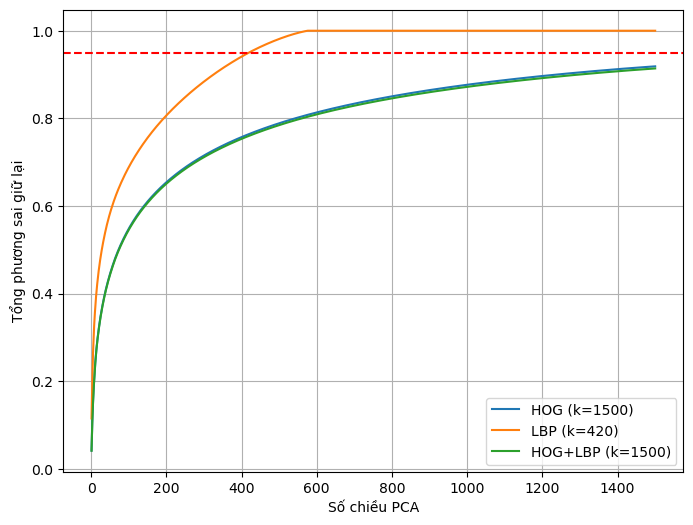

In [54]:
k_max = 1500
threshold = 0.95
plt.figure(figsize=(8,6))

for name, (Xtr, ytr, Xte, yte) in datasets.items():
    scaler = StandardScaler(with_mean=True)
    Xtr_s = scaler.fit_transform(Xtr)

    pca_full = PCA(n_components=k_max, svd_solver='randomized', random_state=42).fit(Xtr_s)
    explained_cum = np.cumsum(pca_full.explained_variance_ratio_)

    if np.any(explained_cum >= threshold):
        k_opt = np.argmax(explained_cum >= threshold) + 1
    else:
        k_opt = len(explained_cum) 

    plt.plot(np.arange(1, len(explained_cum)+1), explained_cum, label=f"{name} (k={k_opt})")

plt.axhline(y=threshold, color='red', linestyle='--')
plt.xlabel("Số chiều PCA")
plt.ylabel("Tổng phương sai giữ lại")
plt.grid(True)
plt.legend()
plt.show()


In [55]:
# mapping số chiều PCA theo descriptor
pca_dims = {
    'LBP': 420,
    'HOG': 1024,
    'HOG+LBP': 1024
}

## Training Model

### Chuẩn bị model huấn luyện

In [56]:
# Các model
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'SVC': SVC(class_weight='balanced'),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42)
}

In [59]:
# Hàm đánh giá
def evaluate_descriptor(desc_name, X_train, y_train, X_test, y_test, models):
    for model_name, model in models.items():
        print(f"\n--- {desc_name} | Model: {model_name} ---")

        pipe = Pipeline([
            ('scaler', StandardScaler(with_mean=True)),
            ('pca', PCA(n_components=pca_dims[desc_name], 
                        svd_solver='randomized', random_state=42)),
            ('clf', model)
        ])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        # In classification report
        print(classification_report(y_test, y_pred))

        # In confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(cm)
    return

### Đánh giá các mô hình

In [60]:
# Chạy tất cả
for desc_name, (X_train, y_train, X_test, y_test) in datasets.items():
    evaluate_descriptor(desc_name, X_train, y_train, X_test, y_test, models)


--- HOG | Model: LogisticRegression ---
              precision    recall  f1-score   support

           0       0.75      0.83      0.79      2534
           1       0.80      0.72      0.76      2478

    accuracy                           0.78      5012
   macro avg       0.78      0.78      0.78      5012
weighted avg       0.78      0.78      0.78      5012

Confusion Matrix:
[[2100  434]
 [ 688 1790]]

--- HOG | Model: SVC ---
              precision    recall  f1-score   support

           0       0.78      0.86      0.81      2534
           1       0.84      0.75      0.79      2478

    accuracy                           0.80      5012
   macro avg       0.81      0.80      0.80      5012
weighted avg       0.81      0.80      0.80      5012

Confusion Matrix:
[[2171  363]
 [ 623 1855]]

--- HOG | Model: RandomForest ---
              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2534
           1       0.63      0.63      0.63  